# User settings

In [1]:
# change name of file
PLATE_IMG = "/Users/pmagwene/Desktop/Region001-EQLZD-2018-12-17-DM-test10-b5d40703-0007-20181218T004309.tiff"

# change number of rows and cols as appropriate
NROWS = 8
NCOLS = 12

# change if you'd like larger or smaller figs
FIG_SIZE = (10,8)

# Imports

In [2]:
import numpy as np
import scipy as sp

from matplotlib import pyplot as plt
import skimage
from skimage import (morphology, segmentation, exposure, feature, filters,
                     measure, transform, util, io, color)

from toolz.curried import *

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets.widgets.interaction import show_inline_matplotlib_plots

from spotz import imgz, gridder2, segmenter2, spotzplot

%matplotlib inline

# Original and inverted image

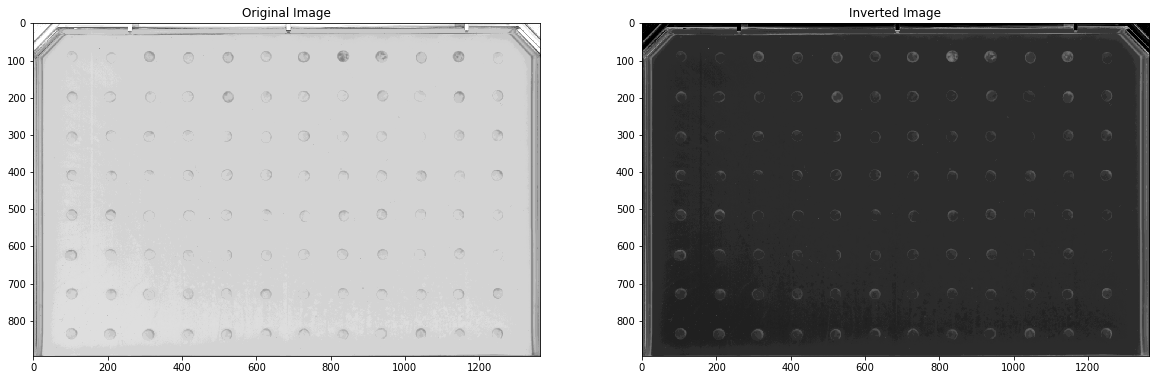

In [3]:
img = imgz.read_image(PLATE_IMG)
iimg = imgz.invert(img)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(FIG_SIZE[0]*2, FIG_SIZE[1])

imgz.imshowg(img, ax1)
ax1.set_title("Original Image")
imgz.imshowg(iimg, ax2)
ax2.set_title("Inverted Image")

pass

# Gridding

In [4]:

def threshold_and_open(img, invert, threshold, opensize):
    rbimg = pipe(img,
                 lambda x: imgz.invert(x) if invert else x,
                 lambda x: x > threshold, 
                 imgz.disk_opening(opensize),
                 imgz.clear_border)   
    return rbimg

def find_grid(img):
    g = gridder2.find_grid(NROWS, NCOLS, img)
    return g

def display_threshold_and_grid(img, invert, threshold, opensize):
    rbimg = threshold_and_open(img, invert, threshold, opensize)
    g = find_grid(rbimg)
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(FIG_SIZE[0]*2, FIG_SIZE[1])
    
    imgz.imshowg(rbimg, ax1)
    imgz.imshowg(rbimg, ax2)
    ax2.plot(g.centers[:,1], g.centers[:,0], 'r.')
    spotzplot.draw_bboxes(g.bboxes, ax2)
    
    return rbimg, g
    

wInvert = widgets.Checkbox(
    value=True,
    description='Invert',
    disabled=False)

wThresh = widgets.IntSlider(
    description="Threshold: ",
    value=filters.threshold_otsu(imgz.invert(img)),
    min=1, max=2**16-1, step=100, 
    continuous_update=False)

wOpen = widgets.IntSlider(
    description="Disk Opening: ",
    value=3,
    min=1, max=10, step=1, 
    continuous_update=False)

threshold_display = interactive(display_threshold_and_grid, 
                                img=fixed(img), 
                                invert=wInvert, 
                                threshold = wThresh, 
                                opensize = wOpen)


In [5]:
display(threshold_display)

interactive(children=(Checkbox(value=True, description='Invert'), IntSlider(value=16587, continuous_update=Fal…

# Local thresholding and Watershed segmentation

In [14]:
def threshold_bboxes(img, grid, minlocal, objsize, holesize, disksize, thresholdfunc):
    timg = pipe(img,
            segmenter2.threshold_bboxes(grid.bboxes, threshold_func=thresholdfunc, min_local_threshold=minlocal), 
            imgz.remove_small_objects(objsize),
            imgz.remove_small_holes(holesize),
            imgz.disk_closing(disksize),
            imgz.clear_border)
    return timg


def filter_on_grid(timg, grid):
    filtered_img, filtered_regions = segmenter2.assign_objects_to_grid(grid.centers, 
                                                                   timg, 
                                                                   maxdist = 30) 
    filtered_bboxes = [r.bbox if r else None for r in filtered_regions]
    return filtered_img, filtered_regions, filtered_bboxes


def watershed_bboxes(iimg, timg, grid, filtered_bboxes):
    wshed = segmenter2.watershed_segment_bboxes(grid.centers, 
                                             filtered_bboxes, 
                                             iimg, timg, 
                                             seed_width = 5) 
    return wshed


def display_rethreshold(iimg,  minlocal, objsize, holesize, disksize, thresholdfunc, globalthresh):
    grid = threshold_display.result[1]
    if globalthresh:
        timg = threshold_display.result[0]
    else:
        timg = threshold_bboxes(iimg, grid, minlocal, objsize, holesize, disksize, thresholdfunc)
    
    filtered_img, filtered_regions, filtered_bboxes = filter_on_grid(timg, grid)
    
    wshed = watershed_bboxes(iimg, timg, grid, filtered_bboxes) 
    
    
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
    fig.set_size_inches(FIG_SIZE[0]*2, FIG_SIZE[1]*2)
     
    imgz.imshowg(timg, ax1)
    imgz.imshowg(filtered_img > 0, ax2)    
    ax3.imshow(color.label2rgb(wshed, img, bg_label = 0))
    spotzplot.draw_image_and_labels(img, wshed, ax = ax4,
                                          mask_cmap = "Reds", alpha = 0.35,
                                         fontsize = 14, textcolor = "darkgoldenrod") 
    
    plt.tight_layout()
    
    return timg


wMin = widgets.FloatSlider(description="Min Local: ",
                      value=0.5,
                      min=0, max=1, step=0.01, 
                      continuous_update=False)

wObjsize = widgets.IntSlider(description="Object size: ",
                      value=50,
                      min=1, max=100, step=1, 
                      continuous_update=False)

wHolesize = widgets.IntSlider(description="Hole size: ",
                      value=50,
                      min=1, max=100, step=1, 
                      continuous_update=False)

wClose = widgets.IntSlider(description="Disk Closing: ",
                      value=3,
                      min=1, max=10, step=1, 
                      continuous_update=False)

wLocalFuncs = widgets.Dropdown(
    options=[('Otsu', filters.threshold_otsu), 
             ('Li', filters.threshold_li), 
             ('Yen', filters.threshold_yen),              
             ('Mean', filters.threshold_mean),
            ('Triangle', filters.threshold_triangle)],
    value=filters.threshold_li,
    description='Threshold function:',
)

wUseGlobal = widgets.Checkbox(
    value=False,
    description='Use Global Threshold',
    disabled=False)




segmentation_display = interactive(display_rethreshold, iimg = fixed(iimg),
                minlocal = wMin, objsize = wObjsize, holesize = wHolesize, disksize=wClose, 
                                   thresholdfunc=wLocalFuncs, globalthresh=wUseGlobal)

def update_local(change):
    segmentation_display.update()
    
threshold_display.out.observe(update_local)
    


display(segmentation_display)

interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='Min Local: ', max=1.0, step…